# Language Model trained with MLP

- Context window is 3 tokens wide.
- Much superior to Bigram.
- This implementation will be a character language model, i.e., given a sequence of characters, it will predict the next character in the sequence.

In [122]:
import torch
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [123]:
device = torch.device('cpu')

### Load 'names.txt' Dataset

In [124]:
names = open('names_indian.txt', 'r').read().splitlines()
print(f"Total Names: {len(names)}", *names[:5], "...", sep=", ")

Total Names: 6466, aabid, aabida, aachal, aadesh, aadil, ...


### Dictionaries to convert characters to int and back

In [125]:
ctoi = {c:i for i, c in enumerate(['.'] + sorted(list(set(''.join(names)))))}
itoc = {i:c for c, i in ctoi.items()}

### Define Block Size

It is the size of the context window. Here, 3 characters are used as it provides a good balance, according to the dataset.

In [126]:
block_size = 3

Using a rolling window to create dataset. `.` character is used as the delimiter.

In [127]:
def build_dataset(words, block_size=block_size):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for c in word + '.':
            ci = ctoi[c]
            X.append(context)
            Y.append(ci)
            # print(''.join(itoc[c] for c in context) + ' ---> ' + itoc[ci])
            context = context[1:] + [ci]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y


In [128]:
X, Y = build_dataset(names, block_size=block_size)

### Splitting Data into Training, Validation and Testing

- Training data proportion: 80%     [`Xtrn, Ytrn`]
- Validation data proportion: 10%   [`Xdev, Ydev`]
- Testing data proportion: 10%      [`Xtst, Ytst`]

Data is shuffled to get more accurate results when testing on Xdev / Xtst

In [129]:
trnProp = 0.8
valProp = 0.1

n1 = int(trnProp*len(names))
n2 = int((trnProp + valProp)*len(names))

random.shuffle(names)

Xtrn, Ytrn = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtst, Ytst = build_dataset(names[n2:])

In [130]:
Ytrn.shape, Ydev.shape, Ytst.shape

(torch.Size([38144]), torch.Size([4715]), torch.Size([4712]))

### Define Hyper parameters
- `dims`: number of dimensions used for encoding each token
- `hidden_layer`: number of neurons in the hidden layer of the network

In [131]:
dims = 15
hidden_layer = 150
# dims = 5
# hidden_layer = 100

### Define Model parameters

- `C` : Defines the point in the n-dimensional space for each character
  - Size: `vocab_size` x `dims`
- `W1` : Weights for the first layer
  - Size: `(dims * block_size)` x `hidden_layer`
- `b1` : Bias for the first layer
  - Size: `hidden_layer` x `1`
- `W2` : Weights for the second layer
  - Size: `hidden_layer` x `vocab_size`
- `b2` : Bias for the second layer
  - Size: `vocab_size` x `1`

In [132]:
tanh_gain = 5/3
std = tanh_gain / (dims*block_size)**0.5

In [133]:
g = torch.Generator(device=device).manual_seed(0)
C = torch.randn((27, dims),                         generator=g, device=device)

W1 = torch.randn((dims*block_size, hidden_layer),   generator=g, device=device) * std
# b1 = torch.randn(hidden_layer,                      generator=g, device=device) * 0.01

W2 = torch.randn((hidden_layer, 27),                generator=g, device=device) * 0.01
b2 = torch.randn(27,                                generator=g, device=device) * 0

bngain = torch.ones((1, hidden_layer))
bnbias = torch.zeros((1, hidden_layer))

bnmean_running = torch.zeros((1, hidden_layer))
bnstd_running = torch.zeros((1, hidden_layer))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(f"Total Parameter: {sum(p.nelement() for p in parameters)}")

Total Parameter: 11682


In [134]:
for p in parameters:
    p.requires_grad = True

In [135]:
losstrn = [] # For tracking loss during training

### Training
- `nitr` : Number of iterations
- `lrs` : Array of learning rates
- Batch size for training: 64

In [136]:
# nitr = 200000
nitr = 40000
lrs = torch.linspace(0.1, 0.001, nitr)
for g in range(nitr):
    # batching
    ix = torch.randint(0, Xtrn.shape[0], (64,))
    # forward pass
    emb = C[Xtrn[ix]]
    hpreact = emb.view((-1, block_size*dims)) @ W1 # + b1
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = (hpreact - bnmeani) / bnstdi  # BatchNorm
    hpreact = (hpreact * bngain) + bnbias

    # Running calculation of mean and std
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrn[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[g]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    losstrn.append(loss)

### Plot of log loss vs iterations

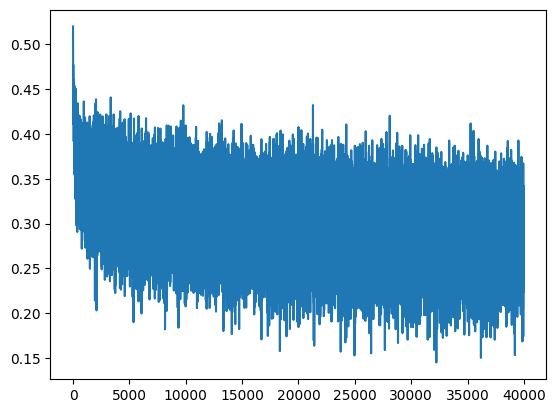

In [137]:
plt.plot(list(map(lambda x: x.log10().item(), losstrn)))

In [138]:
with torch.no_grad():
    emb = C[Xtrn]
    hpreact = emb.view((-1, block_size*dims)) @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

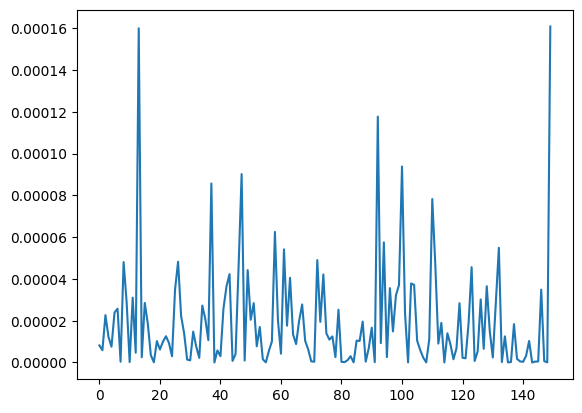

In [139]:
plt.plot((bnmean.view(-1) - bnmean_running.view(-1)) ** 2)

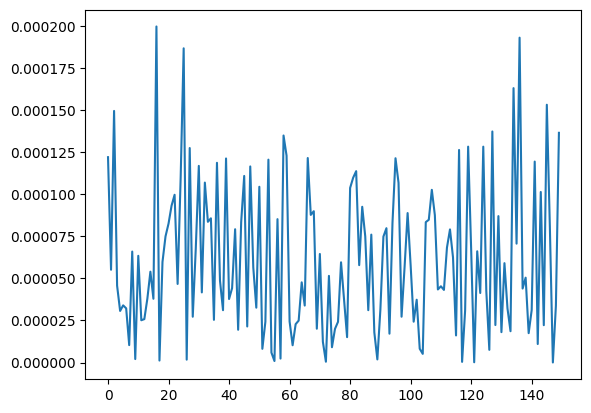

In [140]:
plt.plot((bnstd.view(-1) - bnstd_running.view(-1)) ** 2)

Function to calculate loss on given dataset

In [141]:
@torch.no_grad
def getloss(X, Y):
    emb = C[X]
    hpreact = emb.view((-1, block_size*dims)) @ W1 + # b1
    # hpreact = (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True)  # BatchNorm
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

### Print the loss on the training, validation and testing datasets

In [142]:
print(f"Training Loss: {getloss(Xtrn, Ytrn).item()}")
print(f"Validation Loss: {getloss(Xdev, Ydev).item()}")
print(f"Testing Loss: {getloss(Xtst, Ytst).item()}")

Training Loss: 1.9085776805877686
Validation Loss: 2.087953805923462
Testing Loss: 2.0997612476348877


(array([1011.,  434.,  317.,  264.,  244.,  197.,  211.,  197.,  146.,
         145.,  128.,  164.,  118.,  127.,  125.,  118.,  103.,  100.,
         107.,   94.,  122.,   90.,  106.,   96.,  101.,  104.,   99.,
          96.,   90.,   77.,  111.,   94.,  112.,  116.,  121.,  131.,
         136.,  123.,  134.,  126.,  163.,  171.,  189.,  193.,  192.,
         236.,  267.,  379.,  430.,  845.]),
 array([-9.99969244e-01, -9.59970528e-01, -9.19971812e-01, -8.79973096e-01,
        -8.39974380e-01, -7.99975663e-01, -7.59976947e-01, -7.19978231e-01,
        -6.79979515e-01, -6.39980799e-01, -5.99982083e-01, -5.59983367e-01,
        -5.19984651e-01, -4.79985934e-01, -4.39987218e-01, -3.99988502e-01,
        -3.59989786e-01, -3.19991070e-01, -2.79992354e-01, -2.39993638e-01,
        -1.99994922e-01, -1.59996206e-01, -1.19997489e-01, -7.99987733e-02,
        -4.00000572e-02, -1.34110451e-06,  3.99973750e-02,  7.99960911e-02,
         1.19994807e-01,  1.59993523e-01,  1.99992239e-01,  2.399909

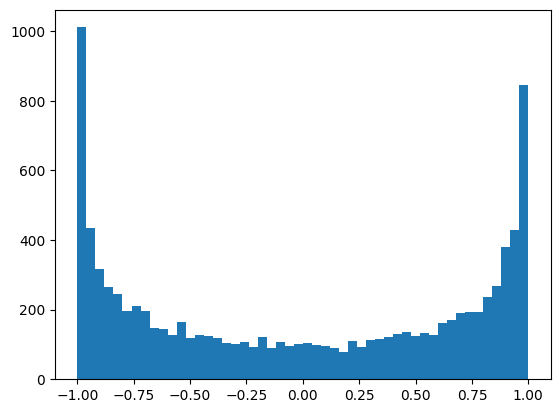

In [143]:
plt.hist(h.view(-1).tolist(), bins=50)

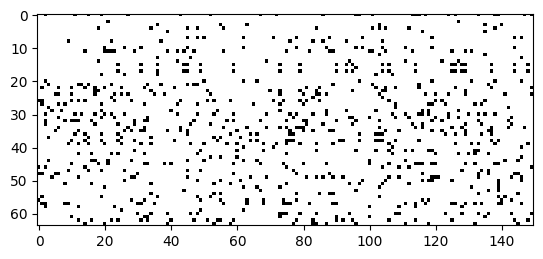

In [144]:
plt.imshow(h.abs() < 0.99, cmap='gray', interpolation='nearest')

### Function to generate a new word based using current model

In [146]:
@torch.no_grad
def generate():
    op = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        hpreact = emb.view((1, -1)) @ W1 # + b1
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        nxti = torch.multinomial(probs, num_samples=1).item()
        if nxti == 0: return ''.join([itoc[x] for x in op])
        context = context[1:] + [nxti]
        op.append(nxti)

### Generate and print 20 samples

In [155]:
for _ in range(20): print(generate())

maninder
chholi
bodharipfi
bhhaesamarira
hushma
lal
lok
sarskhsoan
rujveejakiru
vipna
bai
anuddika
job
reet
sahoolwana
faram
nita
snni
aashu
ravi
